# PROJETO BANK MARKETING STRATEGY

## INPUT

Você foi contratado como um cientista de dados consultor, para criar um produto de dados que cria uma segmentação de clientes que direcionará a estratégia de marketing e os resultados esperados do seu trabalho de consultoria, são os seguintes:

1. Criar uma segmentação de clientes baseado em critérios claros de seleção.
2. Tornar a segmentação de clientes acessível para o time de operações.
3. Ensinar o time de operações sobre como usar a sua solução.
4. Transferir o conhecimento para os Cientistas de Dados da International Bank.
5. Recomendar 2-3 alavancas de negócio para cada segmento de clientes.

## OUTPUT

Painel de PowerBI

## TASKS

Descrição dos dados
- Substituição de NA's

EDA
- Análise Univariada 
- Análise Bivariada
- Detecação de outliers
- Seleção de Features
- Estudo do EspaçoDefinição do Embedding

Treinamento dos algoritmos de ML.
- Análise de Performance
- Análise de Clustering
- Definição dos número de clustering.

Insights
- Explicação das características dos segmentos


Arquitetura da AWS.
- S3 para armazenar os dados
- EC2 para armazenar o ETL e a ferramenta de visualização.
- DB para armazenar a tabela
- Cronjob
- Papermill


# 0.0 IMPORTS

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import ensemble as en
from sklearn import preprocessing as pp

sns.set()

In [2]:
df_raw = pd.read_csv('Data/CC GENERAL.csv')

In [3]:
df_raw.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# 1.0 DATA DESCRIPTION

In [4]:
df01 = df_raw.copy()

## 1.1 Data Dimensions

In [5]:
print( 'Number of rows: {}'.format( df01.shape[0] ) )
print( 'Number of cols: {}'.format( df01.shape[1] ) )

Number of rows: 8950
Number of cols: 18


## 1.2 Columns Rename

In [6]:
df01.columns = df01.columns.str.lower()

## 1.3 Data Types

In [7]:
df01.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4 Checking Missing Values

In [8]:
df01.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

## 1.5 Replace Missing Values

In [9]:
df01 = df01.dropna()

## 1.6 Descriptive Statistics

In [10]:
num_attributes = df01.select_dtypes(include=['int64','float64'])
cat_attributes = df01.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.6.1 Numerical Attributes

In [11]:
# estimadores de localização (media, mediana, min, max)

est1 = pd.DataFrame(num_attributes.apply(np.mean)).T
est2 = pd.DataFrame(num_attributes.apply(np.median)).T
est3 = pd.DataFrame(num_attributes.apply(np.min)).T
est4 = pd.DataFrame(num_attributes.apply(np.max)).T

# estimadores de variabilidade (desvio padrão, amplitude)

est5 = pd.DataFrame(num_attributes.apply(np.std)).T
est6 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

# skewness e kurtosis

est7 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
est8 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate

m1 = pd.concat([est3, est4, est6, est1, est2, est5, est7, est8]).T.reset_index()

m1.columns = ['attributes', 'min', 'max', 'amplitude', 'media', 'mediana', 'desvio_padrao', 'skewness', 'kurtosis']

# percentis
quartis = num_attributes.apply( lambda x: np.percentile( x, q=[10, 25, 50, 75, 95, 99] ) ).T.reset_index()
quartis.columns = ['attributes', 'P10', 'P25', 'P50', 'P75', 'P95', 'P99']


m2 = pd.merge( m1, quartis, how='inner', on='attributes' )
m2

,attributes,min,max,amplitude,media,mediana,desvio_padrao,skewness,kurtosis,P10,P25,P50,P75,P95,P99
0,balance,0.000000,19043.13856,19043.138560,1601.224893,916.855459,2095.449969,2.374254,7.553876,29.093764,148.095189,916.855459,2105.195853,5936.635587,9369.550879
1,balance_frequency,0.000000,1.00000,1.000000,0.895035,1.000000,0.207685,-2.084161,3.369586,0.545455,0.909091,1.000000,1.000000,1.000000,1.000000
2,purchases,0.000000,49039.57000,49039.570000,1025.433874,375.405000,2166.982511,8.055789,108.677684,0.000000,43.367500,375.405000,1145.980000,4060.092500,9127.092000
3,oneoff_purchases,0.000000,40761.25000,40761.250000,604.901438,44.995000,1684.210284,9.935776,160.121308,0.000000,0.000000,44.995000,599.100000,2728.372500,6783.896500
4,installments_purchases,0.000000,22500.00000,22500.000000,420.843533,94.785000,917.192075,7.216133,94.193373,0.000000,0.000000,94.785000,484.147500,1800.000000,3916.483000
5,cash_advance,0.000000,47137.21176,47137.211760,994.175523,0.000000,2121.335473,5.139629,52.143523,0.000000,0.000000,0.000000,1132.385490,4721.415498,9681.634354
6,purchases_frequency,0.000000,1.00000,1.000000,0.496000,0.500000,0.401249,0.033041,-1.638001,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000
7,oneoff_purchases_frequency,0.000000,1.00000,1.000000,0.205909,0.083333,0.300036,1.504234,1.058206,0.000000,0.000000,0.083333,0.333333,1.000000,1.000000
8,purchases_installments_frequency,0.000000,1.00000,1.000000,0.368820,0.166667,0.398070,0.487753,-1.419279,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000
9,cash_advance_frequency,0.000000,1.50000,1.500000,0.137604,0.000000,0.201780,1.795915,3.184233,0.000000,0.000000,0.000000,0.250000,0.583333,0.833333


In [12]:
### Balance: Quanto eu já gastei no cartão ( Fatura atual )
## Possiveis Outliers

### Segunda Opção sobre o Balance ( Saldo ): Fatural atual - limite do cartão. O quanto falta de limite disponível para compra.
## Possiveis Outliers

## Balance Frequency: Frequência de uso do cartão ( usabilidade )

## Purchases: O valor gasto no cartão acumulado dos últimos 6 meses ( a soma de todos os valores quando a pessoa passou o cartão na máquina de cartão )

## Purchases On-Off: A soma de todas as compras pagas 1x no cartão, nos últimos 6 meses.
## ( Categoria )

## Installmente Purchases: A soma de todas as compras pagas em mais de 1x no cartão, nos últimos 6 meses.
## ( Categoria )

## Cash Advance: Valor do saque do limite do cartão de crédito, acumulado dos últimos 6 meses.
## Um adiantamento em dinheiro é basicamente um empréstimo de curto prazo oferecido pelo emissor do 
## cartão de crédito . Quando você pega um adiantamento em dinheiro, está tomando dinheiro emprestado 
## contra a linha de crédito do seu cartão.

## Purchases Frequency: Um valor de 0 a 1 que identifica a frequência de compra do cliente

## Cash Advance Frequency: A frequência com que o cliente faz retiradas de dinheiro do seu cartão de crédito.

## Cash Advance TRX: A quantidade de saques da conta do cartão de crédito

## Purchases TRX: A quantidade de compras realizadas no cartão de crédito.

## Credit Limit: O limite do cartão de crédito.

## Payments: O valor pago além do mínimo da fatura ( não necessariamente a fatura toda )

## Minimum Payments: O valor mínimo pago da fatura

## Por exemplo:
## Fatura total ( Payments ): 3000 
## Pagamento mínimo ( mínimum payments ): 2000 
## Pagamento efetivo de R$2.500

## Payment = 500 
## Minimum payments = 2000
## Pagamento efeito = Payments + Minimum Payments

## Tenure: O tempo de posse do cartão em meses ( O tempo em que a pessoa é cliente do banco )

# 2.0 DATA FILTERING

In [15]:
df20 = df01.copy()

# 3.0 FEATURE ENGINEERING

In [16]:
df30 = df20.copy()

In [17]:
df30.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


In [18]:
# pagamento a vista ou não
df30['one_payment'] = df30['oneoff_purchases'].apply(lambda x: 0 if x == 0.00 else 1)

# gasto médio por transação de compra
df30['avg_ticket_purchases'] = df30['purchases'] / df30['purchases_trx']

# gasto médio por transação de compra totais
df30['avg_ticket_expenses'] = (df30['purchases'] + df30['cash_advance']) / (df30['purchases_trx'] + df30['cash_advance'])

# soma das despesas / soma dos pagamentos
df30['debt_rate'] = (df30['purchases'] + df30['cash_advance']) / (df30['payments'] + df30['minimum_payments'])

# percentual de uso do limite do cartao
df30['credit_limit_rate'] = (df30['purchases'] + df30['cash_advance']) / (6*df30['credit_limit'])

df30 = df30.fillna(0)

# 4.0 EDA - SPACE STUDY

In [19]:
df40 = df30.copy()

C:\Users\herna\anaconda3\envs\bank-marketing\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x1', ylabel='x2'>

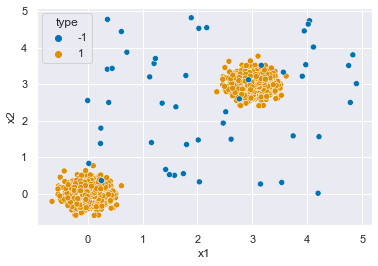

In [20]:
rng = np.random.RandomState( 42 )

# generating training data
X = 0.2*rng.randn( 1000, 2 )

X = np.r_[X+3, X]
X = pd.DataFrame(X, columns=['x1', 'x2'])
X['type'] = 1

# noise data (outliers)
X_outliers = rng.uniform( low=0, high=5, size=(50, 2))
X_outliers = pd.DataFrame( X_outliers, columns =['x1', 'x2'])
X_outliers['type'] = -1

X = pd.concat([X, X_outliers])

sns.scatterplot( 'x1', 'x2', hue='type', palette='colorblind', data=X)

# 5.0 DATA PREPARATION

In [21]:
df50 = df40.copy()

In [22]:
# variável normal e sem outlier = Standard Scaler(x - mean / std)
# variável normal e com outlier = Robust Scaler(x - Q1 / (Q3 - Q1))
# variável não normal = Min Max Scaler( x - min / (max - min))

In [25]:
mm = pp.MinMaxScaler()

df50['balance'] = mm.fit_transform( df50[['balance']])
df50['purchases'] = mm.fit_transform( df50[['purchases']])
df50['oneoff_purchases'] = mm.fit_transform( df50[['oneoff_purchases']])
df50['installments_purchases'] = mm.fit_transform( df50[['installments_purchases']])
df50['cash_advance'] = mm.fit_transform( df50[['cash_advance']])
df50['cash_advance_trx'] = mm.fit_transform( df50[['cash_advance_trx']])
df50['purchases_trx'] = mm.fit_transform( df50[['purchases_trx']])
df50['credit_limit'] = mm.fit_transform( df50[['credit_limit']])
df50['payments'] = mm.fit_transform( df50[['payments']])
df50['minimum_payments'] = mm.fit_transform( df50[['minimum_payments']])
df50['tenure'] = mm.fit_transform( df50[['tenure']])

# 6.0 FEATURE SELECTION

In [ ]:
df01.head()

In [ ]:
cols_drop = ['cust_id']
X = df01.drop(columns=cols_drop)

# 7.0 HYPERPARAMETER FINE TUNING

## 7.1 K-means

In [ ]:
clusters = [2, 3, 4, 5, 6, 7, 8]

silhouette_list = []
db_list=[]

for k in clusters:
    
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)
    
    # model training
    kmeans_model.fit(X)
    
    # model predict
    labels = kmeans_model.predict(X)
    
    # model performance
    sil = m.silhouette_score(X, labels)
    dav = m.davies_bouldin_score(X, labels)
    
    silhouette_list.append(sil)
    db_list.append(dav)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(clusters, silhouette_list, linestyle='--', marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('NÚMERO DE CLUSTERS X SILHOUETTE SCORE', fontweight='bold')

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(clusters, db_list, linestyle='--', marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('DB Index')
plt.title('NÚMERO DE CLUSTERS X DB INDEX', fontweight='bold')

# 8.0 MACHINE LEARNING TRAINING

# 9.0 CLUSTERING ANALYSIS

# 10.0 EDA - INSIGHT REPORTS

# 11.0 DEPLOY TO PRODUCTION